<a href="https://colab.research.google.com/github/DenPotapov/TechnoTrack_Project/blob/master/inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.autograd import Variable
from tqdm import tqdm
#from libs.service_defs import *
#import torch.autograd as autograd
#from scipy import stats
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

from typing import Tuple, List, Type, Dict, Any

In [48]:
class DS(Dataset):
    def __init__(self, img_dict: str = '', mask=False):
        
        self.dict = np.loadtxt(fname=img_dict, usecols=0, dtype=str)
        self.transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                        ])
        self.mask = mask
        self.img_shape = (256, 256)
    
    def get_mask(self) :
        
        mask_id = np.random.randint(low=0, high=4000)
        mask_fname = './mask/mask_dataset/' + str(mask_id).zfill(5) + '.png'
        mask = cv2.imread(mask_fname, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_shape, interpolation=cv2.INTER_LINEAR)
        mask = mask / 255.0
        return mask

    def __getitem__(self, index):
        
        img_src = self.dict[index]
        img = cv2.imread(img_src)
        img = img / 255.0
        struct_src = img_src[:3] + '_structure' + img_src[3:]
        structure = cv2.imread(struct_src)
        structure = structure / 255.0
        unmasked_structure = structure
        mask = np.zeros_like(img)
        if self.mask :
            mask = self.get_mask()
            mask = np.resize(mask, (256, 256, 1))
            mask = np.repeat(mask, 3, axis=2)
            img = img * (np.ones_like(mask) - mask) + mask * np.ones_like(mask)
            structure = structure * (np.ones_like(mask) - mask) + mask * np.ones_like(mask)
        img = self.transforms(img)
        #img = img.unsqueeze(0)
        structure = self.transforms(structure)
        #structure = structure.unsqueeze(0)
        return (img, mask, structure), unmasked_structure #первое x - на вход генератору, второе для дискриминатора

    def __len__(self):
        return len(self.dict)

In [14]:
dataset = DS(img_dict='dict.txt', mask=True)

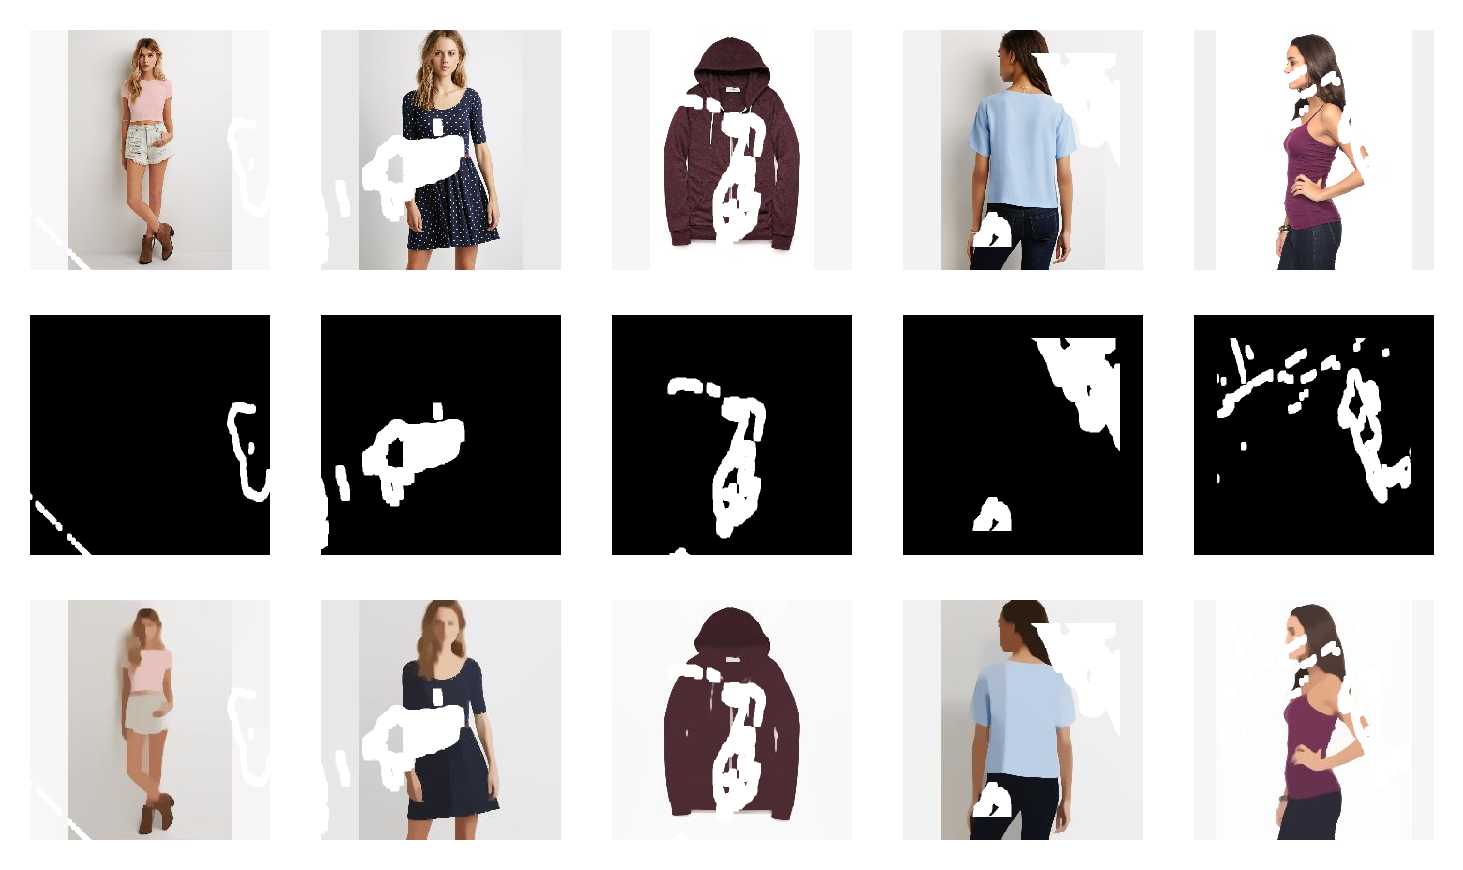

In [52]:
indices = np.random.randint(0, len(dataset), size=5)
samples = [dataset[idx][0] for idx in indices]
fig = plt.figure(figsize=(5, 3), dpi=300)
for idx,sample in enumerate(samples):
    img = sample[0].squeeze(0).permute(1,2,0).numpy()
    p = plt.subplot(3,5,idx+1)
    plt.imshow(img[...,::-1])
    plt.axis('off')
    
    mask = sample[1]
    p = plt.subplot(3,5,5+idx+1)
    plt.imshow(mask)
    plt.axis('off')
    
    structure = sample[2].squeeze(0).permute(1,2,0).numpy()
    p = plt.subplot(3,5,10+idx+1)
    plt.imshow(structure[...,::-1])
    plt.axis('off')
    
plt.tight_layout()
fig.patch.set_facecolor('white')

In [16]:
train_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)

In [18]:
for batch in train_loader : 
    break
batch[0][0].shape

torch.Size([32, 3, 256, 256])

In [19]:
class StructureGen(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=4, activ='relu', 
                 norm='in', pad_type='reflect', use_sn=True):
        super(StructureGen, self).__init__()

        self.down_sample=nn.ModuleList()
        self.up_sample=nn.ModuleList()
        self.content_param=nn.ModuleList()

        self.input_layer = Conv2dBlock(input_dim*2+1, dim, 7, 1, 3, norm, activ, pad_type, use_sn=use_sn)
        self.down_sample += [nn.Sequential(
            Conv2dBlock(dim, 2*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(2*dim, 2*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(2*dim, 4*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(4*dim, 4*dim, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(4*dim, 8*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn))]
        dim = 8*dim
        # content decoder
        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim, dim // 2, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//2, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//2, dim//4, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//4, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//4, dim//8, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]  

        self.content_param += [Conv2dBlock(dim//2, dim//2, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//4, dim//4, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//8, dim//8, 5, 1, 2, norm, activ, pad_type)]                                     

        self.image_net = Get_image(dim//8, input_dim)

    def forward(self, inputs):
        x0 = self.input_layer(inputs)
        x1 = self.down_sample[0](x0)
        x2 = self.down_sample[1](x1)
        x3 = self.down_sample[2](x2)

        u1 = self.up_sample[0](x3) + self.content_param[0](x2)
        u2 = self.up_sample[1](u1) + self.content_param[1](x1)
        u3 = self.up_sample[2](u2) + self.content_param[2](x0)        

        images_out = self.image_net(u3)   
        return images_out  


class Conv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero', dilation=1, 
                 use_bias=True, use_sn=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = use_bias
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if use_sn:
            self.conv = spectral_norm(nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation))
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)           
        if self.activation:
            x = self.activation(x)
        return x


class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out  


class Discriminator(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_layers=3, 
                norm='none', activ='lrelu', pad_type='reflect', use_sn=True):
        super(Discriminator, self).__init__()
        
        self.model = nn.ModuleList()
        self.model.append(Conv2dBlock(input_dim,dim,4,2,1,'none',activ,pad_type,use_sn=use_sn))
        dim_in = dim
        for i in range(n_layers - 1):
            dim_out = min(dim*8, dim_in*2)
            self.model.append(DownsampleResBlock(dim_in,dim_out,'none',activ,pad_type,use_sn))
            dim_in = dim_out

        self.model.append(Conv2dBlock(dim_in,1,1,1,activation='none',use_bias=False, use_sn=use_sn))
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class DownsampleResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(DownsampleResBlock, self).__init__()
        self.conv_1 = nn.ModuleList()
        self.conv_2 = nn.ModuleList()

        self.conv_1.append(Conv2dBlock(input_dim,input_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(Conv2dBlock(input_dim,output_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_1 = nn.Sequential(*self.conv_1)


        self.conv_2.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_2.append(Conv2dBlock(input_dim,output_dim,1,1,0,'none',activation,pad_type,use_sn=use_sn))
        self.conv_2 = nn.Sequential(*self.conv_2)


    def forward(self, x):
        out = self.conv_1(x) + self.conv_2(x)
        return out

class MultiDiscriminator(nn.Module):
    def __init__(self, **parameter_dic):
        super(MultiDiscriminator, self).__init__()
        self.model_1 = Discriminator(**parameter_dic)
        self.down = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        self.model_2 = Discriminator(**parameter_dic)
        
    def forward(self, x):
        pre1 = self.model_1(x)
        pre2 = self.model_2(self.down(x))
        return [pre1, pre2]        

class Get_image(nn.Module):
    def __init__(self, input_dim, output_dim, activation='tanh'):
        super(Get_image, self).__init__()
        self.conv = Conv2dBlock(input_dim, output_dim, kernel_size=3, stride=1,
                     padding=1, pad_type='reflect', activation=activation)
    def forward(self, x):
        return self.conv(x) 

In [22]:
class AdversarialLoss(nn.Module):
    r"""
    Adversarial loss
    https://arxiv.org/abs/1711.10337
    """

    def __init__(self, type='nsgan', target_real_label=1.0, target_fake_label=0.0):
        r"""
        type = nsgan | lsgan | hinge
        """
        super(AdversarialLoss, self).__init__()

        self.type = type
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))

        if type == 'nsgan':
            self.criterion = nn.BCELoss()

        elif type == 'lsgan':
            self.criterion = nn.MSELoss()

        elif type == 'hinge':
            self.criterion = nn.ReLU()

    def __call__(self, outputs, is_real, for_dis=None):
        if self.type == 'hinge':
            if for_dis:
                if is_real:
                    outputs = -outputs
                return self.criterion(1 + outputs).mean()
            else:
                return (-outputs).mean()

        else:
            labels = (self.real_label if is_real else self.fake_label).expand_as(outputs)
            loss = self.criterion(outputs, labels)
            return loss


class StyleLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self):
        super(StyleLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()

    def compute_gram(self, x):
        b, ch, h, w = x.size()
        f = x.view(b, ch, w * h)
        f_T = f.transpose(1, 2)
        G = f.bmm(f_T) / (h * w * ch)

        return G

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        # Compute loss
        style_loss = 0.0
        style_loss += self.criterion(self.compute_gram(x_vgg['relu2_2']), self.compute_gram(y_vgg['relu2_2']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu3_4']), self.compute_gram(y_vgg['relu3_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu4_4']), self.compute_gram(y_vgg['relu4_4']))
        style_loss += self.criterion(self.compute_gram(x_vgg['relu5_2']), self.compute_gram(y_vgg['relu5_2']))

        return style_loss



class PerceptualLoss(nn.Module):
    r"""
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self, weights=[1.0, 1.0, 1.0, 1.0, 1.0]):
        super(PerceptualLoss, self).__init__()
        self.add_module('vgg', VGG19())
        self.criterion = torch.nn.L1Loss()
        self.weights = weights

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        content_loss = 0.0
        content_loss += self.weights[0] * self.criterion(x_vgg['relu1_1'], y_vgg['relu1_1'])
        content_loss += self.weights[1] * self.criterion(x_vgg['relu2_1'], y_vgg['relu2_1'])
        content_loss += self.weights[2] * self.criterion(x_vgg['relu3_1'], y_vgg['relu3_1'])
        content_loss += self.weights[3] * self.criterion(x_vgg['relu4_1'], y_vgg['relu4_1'])
        content_loss += self.weights[4] * self.criterion(x_vgg['relu5_1'], y_vgg['relu5_1'])

        return content_loss


class PerceptualCorrectness(nn.Module):
    r"""

    """

    def __init__(self, layer='relu3_1'):
        super(PerceptualCorrectness, self).__init__()
        self.add_module('vgg', VGG19())
        self.layer = layer  
        self.eps=1e-8 
        self.resample = Resample2d(4, 1, sigma=2)

    def __call__(self, gts, inputs, flow, maps):
        gts_vgg, inputs_vgg = self.vgg(gts), self.vgg(inputs)
        gts_vgg = gts_vgg[self.layer]
        inputs_vgg = inputs_vgg[self.layer]
        [b, c, h, w] = gts_vgg.shape

        maps = F.interpolate(maps, [h,w]).view(b,-1)
        flow = F.adaptive_avg_pool2d(flow, [h,w])

        gts_all    = gts_vgg.view(b, c, -1)                               #[b C N2]
        inputs_all = inputs_vgg.view(b, c, -1).transpose(1,2)             #[b N2 C]


        input_norm = inputs_all/(inputs_all.norm(dim=2, keepdim=True)+self.eps)
        gt_norm    = gts_all/(gts_all.norm(dim=1, keepdim=True)+self.eps)
        correction = torch.bmm(input_norm, gt_norm)                       #[b N2 N2]
        (correction_max,max_indices) = torch.max(correction, dim=1)

        # interple with gaussian sampling
        input_sample = self.resample(inputs_vgg, flow)
        input_sample = input_sample.view(b, c, -1)                        #[b C N2]

        correction_sample = F.cosine_similarity(input_sample, gts_all)    #[b 1 N2]
        loss_map = torch.exp(-correction_sample/(correction_max+self.eps))
        loss = torch.sum(loss_map*maps)/(torch.sum(maps)+self.eps)
        
        return loss




class VGG19(torch.nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        features = models.vgg19(pretrained=True).features
        self.relu1_1 = torch.nn.Sequential()
        self.relu1_2 = torch.nn.Sequential()

        self.relu2_1 = torch.nn.Sequential()
        self.relu2_2 = torch.nn.Sequential()

        self.relu3_1 = torch.nn.Sequential()
        self.relu3_2 = torch.nn.Sequential()
        self.relu3_3 = torch.nn.Sequential()
        self.relu3_4 = torch.nn.Sequential()

        self.relu4_1 = torch.nn.Sequential()
        self.relu4_2 = torch.nn.Sequential()
        self.relu4_3 = torch.nn.Sequential()
        self.relu4_4 = torch.nn.Sequential()

        self.relu5_1 = torch.nn.Sequential()
        self.relu5_2 = torch.nn.Sequential()
        self.relu5_3 = torch.nn.Sequential()
        self.relu5_4 = torch.nn.Sequential()

        for x in range(2):
            self.relu1_1.add_module(str(x), features[x])

        for x in range(2, 4):
            self.relu1_2.add_module(str(x), features[x])

        for x in range(4, 7):
            self.relu2_1.add_module(str(x), features[x])

        for x in range(7, 9):
            self.relu2_2.add_module(str(x), features[x])

        for x in range(9, 12):
            self.relu3_1.add_module(str(x), features[x])

        for x in range(12, 14):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(14, 16):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(16, 18):
            self.relu3_4.add_module(str(x), features[x])

        for x in range(18, 21):
            self.relu4_1.add_module(str(x), features[x])

        for x in range(21, 23):
            self.relu4_2.add_module(str(x), features[x])

        for x in range(23, 25):
            self.relu4_3.add_module(str(x), features[x])

        for x in range(25, 27):
            self.relu4_4.add_module(str(x), features[x])

        for x in range(27, 30):
            self.relu5_1.add_module(str(x), features[x])

        for x in range(30, 32):
            self.relu5_2.add_module(str(x), features[x])

        for x in range(32, 34):
            self.relu5_3.add_module(str(x), features[x])

        for x in range(34, 36):
            self.relu5_4.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        relu1_1 = self.relu1_1(x)
        relu1_2 = self.relu1_2(relu1_1)

        relu2_1 = self.relu2_1(relu1_2)
        relu2_2 = self.relu2_2(relu2_1)

        relu3_1 = self.relu3_1(relu2_2)
        relu3_2 = self.relu3_2(relu3_1)
        relu3_3 = self.relu3_3(relu3_2)
        relu3_4 = self.relu3_4(relu3_3)

        relu4_1 = self.relu4_1(relu3_4)
        relu4_2 = self.relu4_2(relu4_1)
        relu4_3 = self.relu4_3(relu4_2)
        relu4_4 = self.relu4_4(relu4_3)

        relu5_1 = self.relu5_1(relu4_4)
        relu5_2 = self.relu5_2(relu5_1)
        relu5_3 = self.relu5_3(relu5_2)
        relu5_4 = self.relu5_4(relu5_3)

        out = {
            'relu1_1': relu1_1,
            'relu1_2': relu1_2,

            'relu2_1': relu2_1,
            'relu2_2': relu2_2,

            'relu3_1': relu3_1,
            'relu3_2': relu3_2,
            'relu3_3': relu3_3,
            'relu3_4': relu3_4,

            'relu4_1': relu4_1,
            'relu4_2': relu4_2,
            'relu4_3': relu4_3,
            'relu4_4': relu4_4,

            'relu5_1': relu5_1,
            'relu5_2': relu5_2,
            'relu5_3': relu5_3,
            'relu5_4': relu5_4,
        }
        return out

In [89]:
def train_model(model_gen: torch.nn.Module, 
                model_dsc: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                optimizer_gen: torch.optim.Optimizer,
                optimizer_dsc: torch.optim.Optimizer,
                batch_size = 64,
                max_epochs = 10):
    
    '''
    В этой функции следует запрограммировать обучение и валидацию WGAN-GP.
    
    '''
    STRUCTURE_L1 = 4
    STRUCTURE_ADV_GEN = 1

    adversarial_loss = AdversarialLoss(type='lsgan')
    l1_loss = nn.L1Loss()
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size,pin_memory=True,num_workers=2)
    
    lr_scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gen, T_max = 40)
    lr_scheduler_dsc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_dsc, T_max = 80)
        
    val_loss_history = []
    gen_loss_history = []
    dsc_loss_history = []
    logs = []
    lgen = 0.0
    ldsc = 0.0
       
    
    for epoch in range(max_epochs):
        print(f'Starting epoch {epoch+1} of {max_epochs}')
        
        model_gen.train()
        model_dsc.train()
        
        with tqdm(total=len(train_loader)) as pbar:
            for idx, ((inputs, maps, smooths_input), y) in enumerate(train_loader): #чет мне кажется что оно может так не считаться. Возможно нужно как-то перестраивать. Пытался скрестить наш даталоадер с их.
                #print(maps.shape)
                maps = maps.permute(0,3,1,2)[:,None,0,:,:]
                print(maps.shape)
                optimizer_dsc.zero_grad()
                real_batch = y.to(DEVICE)
                outputs = model_gen(torch.cat((inputs, smooths_input, maps),dim=1))
            
                fake_batch = outputs.detach()
                real_scores = model_dsc(real_batch)
                fake_scores = model_dsc(fake_batch)
                for i in range(len(fake_scores)):
                    dis_real_loss = adversarial_loss(real_scores[i], True, True)
                    dis_fake_loss = adversarial_loss(fake_scores[i], False, True)
                    dis_loss += (dis_real_loss + dis_fake_loss) / 2
                structure_adv_dis_loss = dis_loss/len(fake_scores)
                structure_adv_dis_loss.backward()
                optimizer_dsc.step()
                lr_scheduler_dsc.step()
                if idx % n_critic == 0:
                    
                    optimizer_gen.zero_grad()
                    fake_scores = model_dsc(fake_batch)
                    for i in range(len(fake_scores)):
                        dis_fake_loss = adversarial_loss(fake_scores[i], True, False)
                        dis_gen_loss += dis_fake_loss
                    structure_adv_gen_loss = dis_gen_loss/len(fake_scores) * STRUCTURE_ADV_GEN
                    structure_l1_loss = l1_loss(outputs, y) * STRUCTURE_L1
                    structure_gen_loss = structure_l1_loss + structure_adv_gen_loss
                    structure_gen_loss.backward()
                    optimizer_gen.step()
                    """
                    if idx % 3 == 0:
                        f = plt.figure(figsize=(2,2), dpi=300)
                        ex = fake_batch[1].detach().cpu().numpy()
                        ex_2 = fake_batch[0].detach().cpu().numpy()
                        print(lr_scheduler_gen.get_last_lr(), np.max(ex),np.min(ex))
                        p = plt.subplot(2,2,1)
                        plt.imshow(ex[0,...], cmap='gray')
                        plt.axis('off')
                        p = plt.subplot(2,2,2)
                        plt.imshow(ex[1,...], cmap='gray')
                        plt.axis('off')
                        p = plt.subplot(2,2,3)
                        plt.imshow(ex_2[0,...], cmap='gray')
                        plt.axis('off')
                        p = plt.subplot(2,2,4)
                        plt.imshow(ex_2[1,...], cmap='gray')
                        plt.axis('off')
                        plt.show()
                    """
                    
                    lr_scheduler_gen.step()
                    logs.append([
                        ("l_s_adv_dis", structure_adv_dis_loss.item()),
                        ("l_s_l1", structure_l1_loss.item()),
                        ("l_s_adv_gen", structure_adv_gen_loss.item()),
                        ("l_s_gen", structure_gen_loss.item()),
                    ])
                pbar.update(1)
                
                pbar.set_postfix({'step': idx+1, 'loss_GEN': loss_gen.item(), 'loss_DSC': loss_dsc.item()})
                
        # Тут рекомендуется сохранять модели каждую эпоху
        #torch.save(gen, path_dir + 'best_gen.pth')
        #torch.save(dsc, path_dir + 'best_dsc.pth')
        
    
        
    return logs

In [90]:
structure_param = {'input_dim':3, 'dim':64, 'n_res':4, 'activ':'relu', 
                        'norm':'in', 'pad_type':'reflect', 'use_sn':False}
dis_param =  {'input_dim':3, 'dim':64, 'n_layers':3, 'norm':'none',
                   'activ':'lrelu', 'pad_type':'reflect', 'use_sn':False}
s_gen = StructureGen(**structure_param)
s_dis = MultiDiscriminator(**dis_param)  

l1_loss = nn.L1Loss()
adversarial_loss = AdversarialLoss()
# correctness_loss = PerceptualCorrectness()
# vgg_style = StyleLoss()
# vgg_content = PerceptualLoss()

In [91]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [92]:
opt_gen = torch.optim.Adam(s_gen.parameters(), lr=1e-4)
opt_dsc = torch.optim.Adam(s_dis.parameters(), lr=1e-4) 

In [93]:
logs = train_model(s_gen, s_dis,
                   dataset,
                   opt_gen, opt_dsc,
                   batch_size = 2,
                   max_epochs=20)

  0%|          | 0/26356 [00:00<?, ?it/s]

Starting epoch 1 of 20


OSError: [Errno 12] Cannot allocate memory